In [88]:
import os
import mc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices, build_design_matrices
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from scipy import stats
from matplotlib.ticker import PercentFormatter


In [2]:
def get_data(sub, trials):
    data_folder = "/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives"
    if not os.path.isdir(data_folder):
        print("running on ceph")
        data_folder = "/ceph/behrens/svenja/human_ABCD_ephys/derivatives"
    if trials == 'residualised':
        res_data = True
    else:
        res_data = False
    data_norm = mc.analyse.helpers_human_cells.load_norm_data(data_folder, [f"{sub:02}"], res_data = res_data)
    return data_norm, data_folder 

In [133]:
state_bins = {
    "A": slice(0, 90),
    "B": slice(90, 180),
    "C": slice(180, 270),
    "D": slice(270, 360),
}

neuron = neurons['50_05-05-elec36-LINS'].to_numpy()

x = neuron[:, state_bins["A"]]
print(x.shape)
print(neuron.shape)

n_bins = 360
state_mean = np.empty(int(n_bins/90), dtype=object)
state_mean[0] = 'A'
print(state_mean)

(248, 90)
(248, 360)
['A' None None None]


In [144]:
def make_long_df_mean_per_state(
    neuron: np.ndarray,
    beh_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    Build a long DataFrame (trials x 4 states) with y, state, state_phase,
    and repeated behavioral columns. Optionally add one-hot columns
    for each state and state_phase category.

    Parameters
    ----------
    neuron : np.ndarray, shape (n_trials, 4 states)
    beh_df : pd.DataFrame, length n_trials, with columns:
             'rep_correct', 'grid_no', 'correct'
    add_one_hot : bool, default True
        If True, add one-hot columns for each category in state and state_phase.
    drop_first : bool, default False
        If True, drop the first category in each set (useful if you'll include
        an intercept in a linear model).

    Returns
    -------
    df_long : pd.DataFrame, shape (n_trials*360, ...)
    """

    n_trials, n_bins = neuron.shape
    assert int(n_bins/90) == 4, "Expected 4 bins per trial."
    assert len(beh_df) == n_trials, "beh_df length must match neuron.shape[0]."

    # --- category definitions ---
    state_categories = ["A", "B", "C", "D"]
    state_bins = {
        "A": slice(0, 90),
        "B": slice(90, 180),
        "C": slice(180, 270),
        "D": slice(270, 360),
    }
    state_phase_categories = [
        "A_early", "A_mid", "A_rew",
        "B_early", "B_mid", "B_rew",
        "C_early", "C_mid", "C_rew",
        "D_early", "D_mid", "D_rew",
    ]

    # --- per-trial bin labels ---
    state_per_bin = np.empty(n_bins, dtype=object)
    for lbl, sl in state_bins.items():
        state_per_bin[sl] = lbl

    state_mean = np.empty(int(n_bins/90), dtype=object)
        
    # --- compute mean per state in each repeat ---
    neuron_state_means = np.empty((n_trials, int(n_bins/90)))
    for i_r, rep in enumerate(neuron):
        for i_s, s in enumerate(["A", "B", "C", "D"]):
            neuron_state_means[i_r, i_s] = np.mean(rep[state_bins[s]])
            state_mean[i_s] = s
            
    
    # --- expand over all trials ---
    y_long = neuron_state_means.reshape(-1)
    
    state_long = np.tile(state_mean, n_trials)

    rep_correct_long = np.repeat(beh_df["rep_correct"].to_numpy(), int(n_bins/90))
    grid_no_long     = np.repeat(beh_df["grid_no"].to_numpy(), int(n_bins/90))
    correct_long     = np.repeat(beh_df["correct"].to_numpy(), int(n_bins/90))

    # --- assemble df ---
    df_long = pd.DataFrame({
        "y": y_long,
        "state": state_long,
        "rep_correct": rep_correct_long,
        "grid_no": grid_no_long,
        "correct": correct_long,
    })

    # keep ordered categoricals
    df_long["state"] = pd.Categorical(df_long["state"],
                                      categories=state_categories, ordered=True)

    # which categories to encode (optionally drop first)
    state_cats_encode = state_categories[1:] if drop_first else state_categories

    # one-hot (int8 for memory efficiency)
    svals = df_long["state"].to_numpy()
    for cat in state_cats_encode:
        df_long[cat] = (svals == cat).astype("int8")
    

    df_long = df_long.replace([np.inf, -np.inf], np.nan)
    df_long = df_long.dropna(subset=["y","A","B","C","D","rep_correct","correct"])
    # keep valid one-hot rows
    df_long = df_long[df_long[["A","B","C","D"]].sum(axis=1) == 1]
    # center repeat count per neuron
    mu_rep = df_long["rep_correct"].mean()
    df_long["rep_c"] = df_long["rep_correct"] - mu_rep

    return df_long


In [50]:
# first step: load data of a single neuron.
# I THINK that session 50, 05 elect36 left insular, is an A state-neuron. look at that one first.
# '50_05-05-elec36-LINS'
sesh = 50
trials = 'all_minus_explore'
# load data
data_raw, source_dir = get_data(sesh, trials=trials)
group_dir_state = f"{source_dir}/group/state_tuning"

print(f"this is the folder {group_dir_state}")


# filter data for only those repeats that were 1) correct and 2) not the first one
data = mc.analyse.helpers_human_cells.filter_data(data_raw, sesh, trials)
beh_df = data[f"sub-{sesh:02}"]['beh'].copy()
neurons = data[f"sub-{sesh:02}"]['normalised_neurons'].copy()
neuron_labels = []
roi_label = []
for n in neurons:
    neuron_labels.append(n)
    if 'ACC' in n or 'vCC' in n or 'AMC' in n or 'vmPFC' in n:
                roi = 'ACC'
    elif 'PCC' in n:
        roi = 'PCC'
    elif 'OFC' in n:
        roi = 'OFC'
    elif 'MCC' in n or 'HC' in n:
        roi = 'hippocampal'
    elif 'EC' in n:
        roi = 'entorhinal'
    elif 'AMYG' in n:
        roi = 'amygdala'
    else:
        roi = 'mixed'
    roi_label.append(roi)

loading files for subject 50
this is the folder /Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives/group/state_tuning


In [15]:
print(len(beh_df))
beh_df.head()


248


,rep_correct,t_A,t_B,t_C,t_D,loc_A,loc_B,loc_C,loc_D,rep_overall,new_grid_onset,session_no,grid_no,correct
0,0,163.96,166.56,168.41,169.51,4,8,1,3,6,159.66,1,1,1
1,1,203.80,209.68,215.15,217.89,4,8,1,3,7,169.51,1,1,0
2,1,240.37,242.25,243.36,244.21,4,8,1,3,8,217.89,1,1,1
3,2,261.02,263.46,266.37,268.13,4,8,1,3,9,244.21,1,1,1
4,3,288.65,290.94,294.78,296.66,4,8,1,3,10,268.13,1,1,0


In [51]:
print(neuron_labels)
print(roi_label)
neuron = neurons['50_05-05-elec36-LINS'].to_numpy()
print(neuron.shape)


['50_10-10-elec59-PCC', '50_09-09-elec43-L_SUPERIOR_TEMPORAL', '50_15-15-elec64-PCC', '50_01-01-elec2-R-WHITE-MATTER', '50_08-08-elec40-LINS', '50_12-12-elec62-PCC', '50_13-13-elec62-PCC', '50_07-07-elec39-LINS', '50_04-04-elec36-LINS', '50_02-02-elec5-R-WHITE-MATTER', '50_16-16-elec64-PCC', '50_03-03-elec6-R-WHITE-MATTER', '50_14-14-elec62-PCC', '50_05-05-elec36-LINS', '50_06-06-elec39-LINS', '50_11-11-elec61-PCC']
['PCC', 'mixed', 'PCC', 'mixed', 'mixed', 'PCC', 'PCC', 'mixed', 'mixed', 'mixed', 'PCC', 'mixed', 'PCC', 'mixed', 'mixed', 'PCC']
(248, 360)


In [24]:
# next, transform into long format:
# one long df that is 248*360 long, 
#neuron: np.ndarray of shape (248, 360)  # trials x bins
#    beh_df: pd.DataFrame with length 248 and columns: 'rep_correct', 'grid_no', 'correct'
#    Returns a long/tidy DataFrame with 248*360 rows and columns:
#      - y (the original neuron values)
#      - state (A/B/C/D per 90 bins)
#      - state_phase (A_early, A_mid, A_rew, ..., D_rew per 30 bins)
#      - rep_correct, grid_no, correct (repeated for each trial across its 360 bins)
neuron = neurons['50_05-05-elec36-LINS'].to_numpy()
df = make_long_df(neuron, beh_df, add_one_hot=True, drop_first=False)
df.head()

,y,state,state_phase,rep_correct,grid_no,correct,A,B,C,D,...,A_rew,B_early,B_mid,B_rew,C_early,C_mid,C_rew,D_early,D_mid,D_rew
0,0.0,A,A_early,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,A,A_early,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,A,A_early,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,A,A_early,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,A,A_early,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# df has columns: y, state (A/B/C/D), and (optionally) one-hot columns A,B,C,D

# ---------- 1) ONE-HOT with ALL FOUR dummies, NO intercept ----------
# (coefficients == group means for A,B,C,D)
X1 = df[["A","B","C","D"]].to_numpy(dtype=float)          # shape: (N,4)
y  = df["y"].to_numpy(dtype=float)

m1 = LinearRegression(fit_intercept=False).fit(X1, y)
beta_onehot = m1.coef_                                     # length-4: [meanA, meanB, meanC, meanD]
yhat_onehot = m1.predict(X1)

print(f"coefs for one-hot-states is {beta_onehot}")


# ---------- 2) CATEGORICAL (treatment coding): drop A, WITH intercept ----------
# (intercept = meanA; B,C,D coefs = (meanB-meanA), etc.)
Xd = pd.get_dummies(df["state"])                           # A,B,C,D columns
Xd = Xd.reindex(columns=["A","B","C","D"], fill_value=0)   # force order
X2 = Xd[["B","C","D"]].to_numpy(dtype=float)               # drop A to avoid collinearity
m2 = LinearRegression(fit_intercept=True).fit(X2, y)

# reconstruct the 4 group means from treatment-coding coefs
meanA = m2.intercept_
meanB = m2.intercept_ + m2.coef_[0]
meanC = m2.intercept_ + m2.coef_[1]
meanD = m2.intercept_ + m2.coef_[2]
beta_from_treatment = np.array([meanA, meanB, meanC, meanD])

print(f"coefs for categorical is A {meanA}, B {meanB}, C {meanC}, D {meanD}")

# predictions from model 2 on the full A/B/C/D indicator matrix
yhat_treat = m2.predict(X2)    # or equivalently (Xd.values @ np.r_[0, m2.coef_] + m2.intercept_) with mapping

# ---------- 3) EASY EQUALITY CHECKS ----------
print("coefs match (means per state)?",
      np.allclose(beta_onehot, beta_from_treatment, atol=1e-10))

print("predictions match?",
      np.allclose(yhat_onehot, yhat_treat, atol=1e-10))


coefs for one-hot-states is [1.80669866 1.02370392 0.9719595  1.42307415]
coefs for categorical is A 1.8066986648745949, B 1.023703924730376, C 0.9719594982084052, D 1.4230741487457639
coefs match (means per state)? True
predictions match? True


In [41]:
# ---------- 1) ONE-HOT with ALL 12 STATE-PHASE dummies, NO intercept ----------
# (coefficients == group means for A,B,C,D)
list_of_state_phases = [
        "A_early", "A_mid", "A_rew",
        "B_early", "B_mid", "B_rew",
        "C_early", "C_mid", "C_rew",
        "D_early", "D_mid", "D_rew",
    ]
X1 = df[list_of_state_phases].to_numpy(dtype=float)          # shape: (N,12)
y  = df["y"].to_numpy(dtype=float)

m1 = LinearRegression(fit_intercept=False).fit(X1, y)
beta_onehot = m1.coef_                                     # length-4: [meanA, meanB, meanC, meanD]
yhat_onehot = m1.predict(X1)

print(f"coefs for one-hot-state-phases is {beta_onehot}")
idx = np.where(beta_onehot == np.max(beta_onehot))
print(f"best fit is {np.max(beta_onehot)} which is {list_of_state_phases[idx[0][0]]}")

coefs for one-hot-state-phases is [3.21196577 1.22087227 0.98725796 1.23107909 0.99060245 0.84943024
 1.12896815 0.83452984 0.95238051 1.78083589 1.29466835 1.19371821]
best fit is 3.211965766129032 which is A_early


In [42]:
# example dataframe
# df has columns: A,B,C,D (one-hot for state), rep_correct, correct, y
# e.g., A,B,C,D are 0/1 columns, exactly one per row
# rep_correct and correct are numeric (e.g., 0/1 or continuous)

# build design matrix
X_state = df[["A","B","C","D"]].to_numpy(float)          # one-hot columns
X_covs  = df[["rep_correct", "correct"]].to_numpy(float) # covariates

# combine: [A,B,C,D, rep_correct, correct]
X = np.hstack([X_state, X_covs])

y = df["y"].to_numpy(float)

# fit regression (no intercept, because we already have full one-hot)
m = LinearRegression(fit_intercept=False).fit(X, y)

beta = m.coef_                                           # [A,B,C,D, rep_correct, correct]
yhat = m.predict(X)

# separate parts
beta_state = beta[:4]
beta_rep_correct = beta[4]
beta_correct = beta[5]

print(f"coefs for one-hot states: {beta_state}")
print(f"coef for rep_correct: {beta_rep_correct:.3f}")
print(f"coef for correct: {beta_correct:.3f}")


#beta_state (A,B,C,D):
#Each is the adjusted mean of y for that state, after controlling for rep_correct and correct.
#(Because you’ve “partialled out” those covariates.)
#beta_rep_correct:
#Change in y for a one-unit increase in rep_correct, holding state and correct fixed.
#beta_correct:
#Change in y for a one-unit increase in correct, holding state and rep_correct fixed.


coefs for one-hot states: [1.8484047  1.06540996 1.01366553 1.46478018]
coef for rep_correct: 0.048
coef for correct: -0.266


In [43]:
mean_covs = df[["rep_correct", "correct"]].mean().to_numpy()
X_mean_covs = np.tile(mean_covs, (4,1))
X_states = np.eye(4)
X_pred = np.hstack([X_states, X_mean_covs])
y_pred = m.predict(X_pred)

print("Adjusted means for each state (A,B,C,D):", y_pred)

# These are the state means adjusted for average covariate levels, 
# exactly the “effect of abcd/state after removing covariate influence”.

Adjusted means for each state (A,B,C,D): [1.80669866 1.02370392 0.9719595  1.42307415]


In [44]:
# --- Build your original matrices (same as before) ---
X_state = df[["A","B","C","D"]].to_numpy(float)          # one-hot states
X_covs  = df[["rep_correct","correct"]].to_numpy(float)  # covariates
X_full  = np.hstack([X_state, X_covs])

y = df["y"].to_numpy(float)

def fit_and_sse(X, y):
    m = LinearRegression(fit_intercept=False).fit(X, y)
    resid = y - m.predict(X)
    return m, float(np.dot(resid, resid))  # SSE

# Full model SSE
m_full, sse_full = fit_and_sse(X_full, y)

# Reduced designs for each "block" we want to evaluate
blocks = {
    "state (A,B,C,D)": slice(0, 4),        # columns 0..3
    "rep_correct": 4,                      # column 4
    "correct": 5                           # column 5
}

results = {}

for name, idx in blocks.items():
    if isinstance(idx, slice):
        keep = np.r_[np.arange(0, X_full.shape[1])[:idx.start],
                     np.arange(0, X_full.shape[1])[idx.stop:]]
    else:
        keep = np.delete(np.arange(X_full.shape[1]), idx)

    X_reduced = X_full[:, keep]
    _, sse_reduced = fit_and_sse(X_reduced, y)

    # Coefficient of partial determination
    r2_partial = (sse_reduced - sse_full) / sse_reduced
    results[name] = r2_partial

# Also compute overall R^2 (optional, for context)
ybar = y.mean()
tss = float(np.dot(y - ybar, y - ybar))
r2_overall = 1.0 - sse_full / tss

print(f"Overall R^2 (full model): {100*r2_overall:6.2f}%")
for k, v in results.items():
    print(f"Partial R^2 for {k:16s}: {100*v:6.2f}%")

    
# Partial R2 for state (A,B,C,D) = variance uniquely explained by the state factor as a whole, 
# after accounting for rep_correct and correct.
# Partial R2 for rep_correct / correct = extra variance each covariate explains beyond the other predictors.
# They won’t generally sum to the overall R2 because predictors overlap; partial 
# R2s are unique contributions conditional on what’s left in the model.

Overall R^2 (full model):   0.20%
Partial R^2 for state (A,B,C,D) :   0.25%
Partial R^2 for rep_correct     :   0.03%
Partial R^2 for correct         :   0.00%


In [ ]:
# and now for all neurons.


In [ ]:
def sse_from_X(X, y):
    m = LinearRegression(fit_intercept=False).fit(X, y)
    r = y - m.predict(X)
    return float(np.dot(r, r))

def partial_r2_dropcols(X, y, cols_to_drop):
    keep = np.array([j for j in range(X.shape[1]) if j not in cols_to_drop])
    sse_reduced = sse_from_X(X[:, keep], y)
    return (sse_reduced - sse_full) / sse_reduced


In [ ]:
# Build design matrices (same as you already do)
X_state = df[["A","B","C","D"]].to_numpy(float)          # one-hot states
X_covs  = df[["rep_correct","correct"]].to_numpy(float)  # covariates
X_full  = np.hstack([X_state, X_covs])
y = df["y"].to_numpy(float)

# Full model SSE and overall R^2 (context)
sse_full = sse_from_X(X_full, y)
tss = float(np.dot(y - y.mean(), y - y.mean()))
r2_overall = 1.0 - sse_full / tss

In [45]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Build design matrices (same as you already do)
X_state = df[["A","B","C","D"]].to_numpy(float)          # one-hot states
X_covs  = df[["rep_correct","correct"]].to_numpy(float)  # covariates
X_full  = np.hstack([X_state, X_covs])
y = df["y"].to_numpy(float)

def sse_from_X(X, y):
    m = LinearRegression(fit_intercept=False).fit(X, y)
    r = y - m.predict(X)
    return float(np.dot(r, r))

# R2 is the difference between data and prediction squared.
# Full model SSE and overall R^2 (context)
sse_full = sse_from_X(X_full, y)
tss = float(np.dot(y - y.mean(), y - y.mean()))
r2_overall = 1.0 - sse_full / tss

def partial_r2_dropcols(X, y, cols_to_drop):
    keep = np.array([j for j in range(X.shape[1]) if j not in cols_to_drop])
    sse_reduced = sse_from_X(X[:, keep], y)
    return (sse_reduced - sse_full) / sse_reduced

# --- Blocks ---
results = {}

# Whole state factor: drop all four dummies at once
results["state (A,B,C,D)"] = partial_r2_dropcols(X_full, y, [0,1,2,3])

# Covariates
results["rep_correct"] = partial_r2_dropcols(X_full, y, [4])
results["correct"]     = partial_r2_dropcols(X_full, y, [5])

# --- Individual states ---
state_names = ["A","B","C","D"]
for j, name in enumerate(state_names):
    results[f"state {name}"] = partial_r2_dropcols(X_full, y, [j])

# Print nicely (percent)
print(f"Overall R^2 (full model): {100*r2_overall:6.2f}%")
for k, v in results.items():
    print(f"Partial R^2 for {k:16s}: {100*v:6.2f}%")

    
# Overall R² = 0.20% → the full model explains almost none of the total variance in y. 
# The signal is tiny.

# Partial R² for state = 0.25% → when you add the 4 state dummies on top of the covariates, 
# they remove 0.25% of the residual variance that remained after the reduced model. 
# It’s fine that this exceeds overall R²; the denominators differ (SSE_reduced vs TSS).
# Per-state partials (A 0.14%, B 0.05%, C 0.04%, D 0.09%) → among the state dummies, 
# A contributes the most uniquely (conditional on the reduced model). These don’t sum to the state-block partial, which is expected due to overlap with covariates and the different denominator.


Overall R^2 (full model):   0.20%
Partial R^2 for state (A,B,C,D) :   0.25%
Partial R^2 for rep_correct     :   0.03%
Partial R^2 for correct         :   0.00%
Partial R^2 for state A         :   0.14%
Partial R^2 for state B         :   0.05%
Partial R^2 for state C         :   0.04%
Partial R^2 for state D         :   0.09%


In [111]:
# Build X exactly like your sklearn design (NO intercept)
cols = ["A","B","C","D","rep_c","correct"]  # include interactions if you want them
X = df_curr_neuron[cols].to_numpy(float)
y = df_curr_neuron["y"].to_numpy(float)


m = LinearRegression(fit_intercept=False).fit(X, y)
print(f"{m.coef_}, {m.coef_}")

# Fit OLS with robust (HC3) SEs; no intercept because X already encodes it
model = sm.OLS(y, X)
res = model.fit(cov_type="HC3")  # "HC3" is a good default; use "nonrobust" if you want classical SEs

# Per-regressor p-values (aligned with 'cols')
betas    = pd.Series(res.params,   index=cols, name="beta")
pvalues  = pd.Series(res.pvalues,  index=cols, name="pval")
tstats   = pd.Series(res.tvalues,  index=cols, name="t")

print(pd.concat([betas, tstats, pvalues], axis=1))

# Main state block (A..D)
print(res.f_test("A = B = C = D = 0"))

# Interaction block (A_rep..D_rep)
print(res.f_test("A_rep = B_rep = C_rep = D_rep = 0"))
groups = df_curr_neuron["subject_id"].to_numpy()  # or session ids
res_cl = model.fit(cov_type="cluster", cov_kwds={"groups": groups})
res_cl.f_test("A = B = C = D = 0")


[ 4.80369913  4.87856029  4.97330011  4.51446642 -0.00948383  0.76447044], [ 4.80369913  4.87856029  4.97330011  4.51446642 -0.00948383  0.76447044]
             beta          t          pval
A        4.803699  13.207025  7.992098e-40
B        4.878560  13.302131  2.249654e-40
C        4.973300  14.033936  9.663613e-45
D        4.514466  12.584543  2.568233e-36
rep_c   -0.009484  -0.327001  7.436670e-01
correct  0.764470   2.228475  2.584886e-02


PatsyError: unrecognized token in constraint
    A = B = C = D = 0
    ^

In [ ]:
# and now for all neurons.


In [74]:
# =========================
# Helpers (tiny & explicit)
# =========================
def clean_per_neuron_df(df):
    # Replace inf with NaN, then drop rows with any NaN in the columns we use
    cols = ["y","A","B","C","D","rep_correct","correct"]
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=cols)
    # (optional) enforce valid one-hot rows
    df = df[df[["A","B","C","D"]].sum(axis=1) == 1]
    return df


def sse_from_X(X, y):
    m = LinearRegression(fit_intercept=False).fit(X, y)
    resid = y - m.predict(X)
    return float(resid @ resid), m

def delta_r2_and_partial_from_drop(X_full, y, drop_cols):
    # Semi-partial ΔR² (on TSS baseline) + partial R² (on reduced SSE baseline)
    tss = float(((y - y.mean())**2).sum())
    sse_full, _ = sse_from_X(X_full, y)
    keep_cols = np.array([j for j in range(X_full.shape[1]) if j not in drop_cols])
    sse_red, _ = sse_from_X(X_full[:, keep_cols], y)
    delta_r2   = (sse_red - sse_full) / tss if tss > 0 else np.nan
    partial_r2 = (sse_red - sse_full) / sse_red if sse_red > 0 else np.nan
    return delta_r2, partial_r2, sse_full, tss

def block_f_test_pvalue(X_full, y, drop_cols):
    # Nested-model F-test for the dropped block
    rank_full = np.linalg.matrix_rank(X_full)
    keep = np.array([j for j in range(X_full.shape[1]) if j not in drop_cols])
    X_red = X_full[:, keep]
    rank_red  = np.linalg.matrix_rank(X_red)

    m_full = LinearRegression(fit_intercept=False).fit(X_full, y)
    sse_full = float(((y - m_full.predict(X_full))**2).sum())

    m_red  = LinearRegression(fit_intercept=False).fit(X_red, y)
    sse_red  = float(((y - m_red.predict(X_red))**2).sum())

    n = X_full.shape[0]
    df1 = rank_full - rank_red
    df2 = n - rank_full
    if df1 <= 0 or df2 <= 0 or sse_full <= 0:
        return np.nan, int(df1), int(df2)

    F = ((sse_red - sse_full) / df1) / (sse_full / df2)
    p = stats.f.sf(F, df1, df2)
    return float(p), int(df1), int(df2)

def per_neuron_metrics(df_curr_neuron):
    # X = [A B C D rep_correct correct], y = df["y"]
    X_state = df_curr_neuron[["A","B","C","D"]].to_numpy(float)
    X_covs  = df_curr_neuron[["rep_correct","correct"]].to_numpy(float)
    X_full  = np.hstack([X_state, X_covs])
    y       = df_curr_neuron["y"].to_numpy(float)

    # Full fit & overall R²
    sse_full, m_full = sse_from_X(X_full, y)
    tss = float(((y - y.mean())**2).sum())
    r2_overall = 1.0 - sse_full / tss if tss > 0 else np.nan

    # Adjusted means at neuron-wise mean covariates
    mean_covs = df_curr_neuron[["rep_correct","correct"]].mean().to_numpy()
    X_pred = np.hstack([np.eye(4), np.tile(mean_covs, (4,1))])  # rows: A,B,C,D
    adj_means = m_full.predict(X_pred)
    pref_by_mean = ["A","B","C","D"][int(np.argmax(adj_means))]

    # State block ΔR² and p-value
    d_state, p_state_partial, _, _ = delta_r2_and_partial_from_drop(X_full, y, [0,1,2,3])
    p_state, df1, df2 = block_f_test_pvalue(X_full, y, [0,1,2,3])

    # Per-state ΔR²
    dA, _pA, *_ = delta_r2_and_partial_from_drop(X_full, y, [0])
    dB, _pB, *_ = delta_r2_and_partial_from_drop(X_full, y, [1])
    dC, _pC, *_ = delta_r2_and_partial_from_drop(X_full, y, [2])
    dD, _pD, *_ = delta_r2_and_partial_from_drop(X_full, y, [3])
    pref_by_delta = ["A","B","C","D"][int(np.argmax([dA,dB,dC,dD]))]

    return {
        "overall_R2": r2_overall,
        "deltaR2_state": d_state,               # semi-partial (on TSS)
        "deltaR2_A": dA, "deltaR2_B": dB, "deltaR2_C": dC, "deltaR2_D": dD,
        "adj_A": adj_means[0], "adj_B": adj_means[1], "adj_C": adj_means[2], "adj_D": adj_means[3],
        "preferred_by_mean": pref_by_mean,
        "preferred_by_delta": pref_by_delta,
        "p_state": p_state, "df1_state": df1, "df2_state": df2
    }



In [65]:
# ------------------------------------------------------------
# Your loop (as you wrote) + collection
# Assumes: neuron_labels, neurons (dict), beh_df, roi_label, make_long_df(...)
# ------------------------------------------------------------
rows = []  # per-neuron summaries we’ll aggregate later

for idx, n in enumerate(neuron_labels):
    curr_neuron = neurons[n].to_numpy()
    df_curr_neuron = make_long_df(curr_neuron, beh_df, add_one_hot=True, drop_first=False)
    curr_roi = roi_label[idx]

    # (Optional) quick inclusion checks
    if df_curr_neuron[["A","B","C","D"]].sum(axis=1).eq(1).mean() < 1.0:
        # skip neurons with invalid state coding
        continue
    if df_curr_neuron["y"].var() <= 0:
        continue

    met = per_neuron_metrics(df_curr_neuron)
    rows.append({
        "neuron_id": n,
        "area": curr_roi,
        **met
    })

per_neuron = pd.DataFrame(rows)
per_neuron.head()

# ----- Top cells by significance (state block) -----
# Sort by p (ascending), then by ΔR²_state (descending) as a tie-breaker
best_cells = (
    per_neuron
    .sort_values(by=["p_state", "deltaR2_state"], ascending=[True, False])
    .loc[:, ["neuron_id","area","deltaR2_state","p_state","overall_R2",
             "preferred_by_mean","preferred_by_delta"]]
)

# Show the top K
K = 15  # adjust as you like
print("\nTop cells best predicted by STATE (sorted by p):")
print(best_cells.head(K).to_string(index=False))




Top cells best predicted by STATE (sorted by p):
                          neuron_id  area  deltaR2_state  p_state  overall_R2 preferred_by_mean preferred_by_delta
      50_03-03-elec6-R-WHITE-MATTER mixed       0.000098 0.000098    0.000068                 A                  A
               50_07-07-elec39-LINS mixed       0.000256 0.000256    0.000029                 D                  D
                50_13-13-elec62-PCC   PCC       0.000512 0.000512    0.000462                 C                  C
               50_08-08-elec40-LINS mixed       0.000885 0.000884    0.000267                 D                  D
                50_11-11-elec61-PCC   PCC       0.001619 0.001617    0.000110                 C                  C
                50_16-16-elec64-PCC   PCC       0.001771 0.001768    0.000208                 A                  A
               50_04-04-elec36-LINS mixed       0.001843 0.001842    0.001137                 A                  A
               50_06-06-elec39

In [66]:
# ------------------------------------------------------------
# GROUP-LEVEL: A) Do areas predict state in general?
#    -> Use ΔR²_state (same denominator across neurons: each neuron’s TSS)
# ------------------------------------------------------------
area_summary = (
    per_neuron
    .groupby("area")["deltaR2_state"]
    .agg(count="count", mean="mean", median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75))
    .reset_index()
)

# Within-area test vs 0 (is ΔR²_state > 0?)
within_tests = []
for area, g in per_neuron.groupby("area"):
    vals = g["deltaR2_state"].values
    try:
        stat, p = stats.wilcoxon(vals, alternative="greater", zero_method="zsplit")
    except ValueError:
        # fallback sign test if too many zeros
        n = (vals != 0).sum()
        n_pos = (vals > 0).sum()
        p = stats.binomtest(n_pos, n, 0.5, alternative="greater").pvalue if n > 0 else 1.0
        stat = np.nan
    within_tests.append({"area": area, "wilcoxon_stat": stat, "p_greater_0": p})
within_tests = pd.DataFrame(within_tests)

# Across-area comparison (do areas differ?)
if per_neuron["area"].nunique() > 1:
    groups = [g["deltaR2_state"].values for _, g in per_neuron.groupby("area")]
    kw_stat, kw_p = stats.kruskal(*groups)
else:
    kw_stat, kw_p = np.nan, np.nan



Per-neuron table (first rows):
                             neuron_id   area  overall_R2  deltaR2_state  \
0                  50_10-10-elec59-PCC    PCC    0.000248       0.002129   
1  50_09-09-elec43-L_SUPERIOR_TEMPORAL  mixed    0.000747       0.015280   
2                  50_15-15-elec64-PCC    PCC    0.000412       0.006888   
3        50_01-01-elec2-R-WHITE-MATTER  mixed    0.000488       0.030030   
4                 50_08-08-elec40-LINS  mixed    0.000267       0.000885   

   deltaR2_A  deltaR2_B  deltaR2_C  deltaR2_D      adj_A      adj_B  \
0   0.001491   0.001877   0.002021   0.001664   4.139242   4.586736   
1   0.013821   0.014330   0.013758   0.014132  13.913583  14.226930   
2   0.006669   0.006147   0.006166   0.005671   8.006084   7.621421   
3   0.028637   0.027177   0.026745   0.027230  32.105119  31.200474   
4   0.000559   0.000682   0.000681   0.000844   0.389454   0.462461   

       adj_C      adj_D preferred_by_mean preferred_by_delta  
0   4.741789   4.3457

In [60]:
# and now for all sessions, all cells.


['PCC',
 'mixed',
 'PCC',
 'mixed',
 'mixed',
 'PCC',
 'PCC',
 'mixed',
 'mixed',
 'mixed',
 'PCC',
 'mixed',
 'PCC',
 'mixed',
 'mixed',
 'PCC']

In [75]:
sessions=list(range(1,64))
trials = 'all_minus_explore'
rows_all = []  # collect all neurons across all sessions
  
for sesh in sessions:
    # ---- load data for session
    data_raw, source_dir = get_data(sesh, trials=trials)
    data = mc.analyse.helpers_human_cells.filter_data(data_raw, sesh, trials)
    subj = f"sub-{sesh:02}"
    beh_df = data[subj]['beh'].copy()
    neurons = data[subj]['normalised_neurons'].copy()

    # ---- build labels + areas
    neuron_labels = []
    roi_label = []
    for n in neurons:
        neuron_labels.append(n)
        if 'ACC' in n or 'vCC' in n or 'AMC' in n or 'vmPFC' in n:
            roi = 'ACC'
        elif 'PCC' in n:
            roi = 'PCC'
        elif 'OFC' in n:
            roi = 'OFC'
        elif 'MCC' in n or 'HC' in n:
            roi = 'hippocampal'
        elif 'EC' in n:
            roi = 'entorhinal'
        elif 'AMYG' in n:
            roi = 'amygdala'
        else:
            roi = 'mixed'
        roi_label.append(roi)

    # ---- per-neuron loop within this session
    for idx, n in enumerate(neuron_labels):
        curr_neuron = neurons[n].to_numpy()
        df_curr_neuron = make_long_df(curr_neuron, beh_df, add_one_hot=True, drop_first=False)

        # --- NEW: clean rows with NaN/inf and invalid one-hot
        df_curr_neuron = clean_per_neuron_df(df_curr_neuron)

        curr_roi = roi_label[idx]

        # Inclusion checks (after cleaning)
        if df_curr_neuron.shape[0] < 20:  # choose a sensible minimum
            continue
        # ensure each state has at least a few trials (prevents fake significance)
        if (df_curr_neuron[["A","B","C","D"]].sum(0) < 5).any():
            continue
        if df_curr_neuron["y"].var() <= 0:
            continue

        met = per_neuron_metrics(df_curr_neuron)
        rows_all.append({
            "neuron_id": n,
            "area": curr_roi,
            "session": sesh,
            "subject": f"sub-{sesh:02}",
            **met
        })


# ===========================
# All neurons across sessions
# ===========================
per_neuron_all = pd.DataFrame(rows_all)



loading files for subject 01
loading files for subject 02
loading files for subject 03
loading files for subject 04
loading files for subject 05
loading files for subject 06
loading files for subject 07
loading files for subject 08
loading files for subject 09
loading files for subject 10
loading files for subject 11
loading files for subject 12
loading files for subject 13
loading files for subject 14
loading files for subject 15
loading files for subject 16
loading files for subject 17
loading files for subject 18
loading files for subject 19
loading files for subject 20
loading files for subject 21
loading files for subject 22
loading files for subject 23
loading files for subject 24
loading files for subject 25
loading files for subject 26
loading files for subject 27
loading files for subject 28
loading files for subject 29
loading files for subject 30
loading files for subject 31
loading files for subject 32
loading files for subject 33
loading files for subject 34
loading files 

In [77]:
per_neuron_all.to_csv('/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives/group/state_tuning/linear_model_results_2025-10-08.csv')

In [81]:
# ------------------------------------------------------------
# GROUP-LEVEL: A) Do areas predict state in general?
#    -> Use ΔR²_state (same denominator across neurons: each neuron’s TSS)
# ------------------------------------------------------------
area_summary = (
    per_neuron_all
    .groupby("area")["deltaR2_state"]
    .agg(count="count", mean="mean", median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75))
    .reset_index()
)

# Within-area test vs 0 (is ΔR²_state > 0?)
within_tests = []
for area, g in per_neuron_all.groupby("area"):
    vals = g["deltaR2_state"].values
    try:
        stat, p = stats.wilcoxon(vals, alternative="greater", zero_method="zsplit")
    except ValueError:
        # fallback sign test if too many zeros
        n = (vals != 0).sum()
        n_pos = (vals > 0).sum()
        p = stats.binomtest(n_pos, n, 0.5, alternative="greater").pvalue if n > 0 else 1.0
        stat = np.nan
    within_tests.append({"area": area, "wilcoxon_stat": stat, "p_greater_0": p})
within_tests = pd.DataFrame(within_tests)

# Across-area comparison (do areas differ?)
if per_neuron_all["area"].nunique() > 1:
    groups = [g["deltaR2_state"].values for _, g in per_neuron_all.groupby("area")]
    kw_stat, kw_p = stats.kruskal(*groups)
else:
    kw_stat, kw_p = np.nan, np.nan

    
# ------------------------------------------------------------
# GROUP-LEVEL: B) Which state is predominantly signaled?
#    -> Choose one rule (consistent). We’ll use preferred_by_mean.
# ------------------------------------------------------------
rule = "preferred_by_mean"  # or "preferred_by_delta"

counts = (
    per_neuron_all
    .pivot_table(index="area", columns=rule, values="neuron_id", aggfunc="count", fill_value=0)
    .reindex(columns=["A","B","C","D"], fill_value=0)
)

# Chi-square test of independence (area × preferred state)
if counts.shape[0] > 1:
    chi2, chi_p, dof, exp = stats.chi2_contingency(counts.values)
    n_total = counts.values.sum()
    cramers_v = np.sqrt(chi2 / (n_total * (min(counts.shape) - 1)))
else:
    chi2 = chi_p = dof = cramers_v = np.nan

# ------------------------------------------------------------
# Nice, compact outputs you can inspect / save
# ------------------------------------------------------------
print("\nPer-neuron table (first rows):")
print(per_neuron_all.head())

print("\nArea summary (ΔR²_state):")
print(area_summary)

print("\nWithin-area tests (ΔR²_state > 0):")
print(within_tests)

print(f"\nAcross-area Kruskal–Wallis: H={kw_stat:.3f}, p={kw_p:.3g}")

print("\nPreferred-state counts by area:")
print(counts)

print(f"\nChi-square area × preferred state: chi2={chi2:.3f}, p={chi_p:.3g}, dof={dof}, Cramér's V={cramers_v:.3f}")




Per-neuron table (first rows):
             neuron_id        area  session subject  overall_R2  \
0  01_01-01-chan99-OFC         OFC        1  sub-01    0.000175   
1  01_04-04-chan113-EC  entorhinal        1  sub-01    0.000155   
2  01_05-05-chan116-EC  entorhinal        1  sub-01    0.000270   
3  01_06-06-chan119-EC  entorhinal        1  sub-01    0.001549   
4  01_07-07-chan120-EC  entorhinal        1  sub-01    0.000638   

   deltaR2_state  deltaR2_A  deltaR2_B  deltaR2_C  deltaR2_D     adj_A  \
0       0.003167   0.002761   0.002847   0.002957   0.002441  5.537591   
1       0.000334   0.000311   0.000166   0.000212   0.000216  0.844152   
2       0.006050   0.005342   0.005036   0.004682   0.005809  6.850581   
3       0.003606   0.002891   0.001973   0.001625   0.001129  3.417827   
4       0.002044   0.001799   0.001752   0.001955   0.001685  0.846414   

      adj_B     adj_C     adj_D preferred_by_mean preferred_by_delta  \
0  5.612452  5.707192  5.248358                 


Top neurons best predicted by STATE (sorted by p):
                    neuron_id subject  session        area  deltaR2_state  p_state  overall_R2 preferred_by_mean preferred_by_delta
      18_20-20-mRT2cHbEb03-EC  sub-18       18  entorhinal       0.042443      0.0    0.000609                 B                  B
        25_04-04-mLF2Ca08-ACC  sub-25       25         ACC       0.041572      0.0    0.000475                 B                  B
        25_06-06-mLT2aHa02-HC  sub-25       25 hippocampal       0.034146      0.0    0.002128                 A                  A
50_01-01-elec2-R-WHITE-MATTER  sub-50       50       mixed       0.030030      0.0    0.000488                 A                  A
       09_13-13-mLT2aHaE04-EC  sub-09        9  entorhinal       0.026342      0.0    0.000111                 C                  C
       58_11-11-mLT2bHbE04-EC  sub-58       58  entorhinal       0.024364      0.0    0.000326                 B                  B
        25_32-32-mRT2bHb

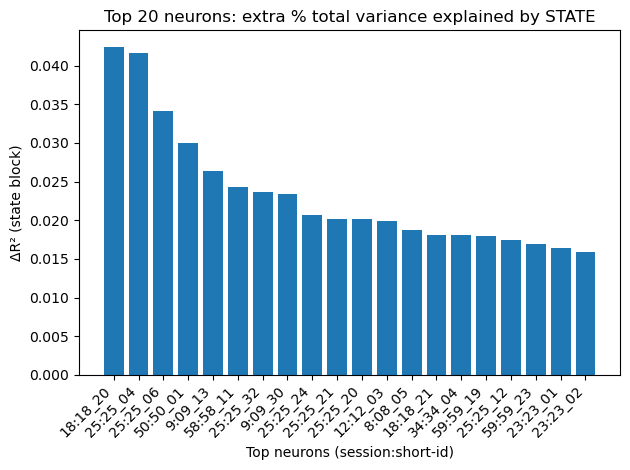


Area summary (ΔR²_state):
           area  count      mean    median       q25       q75
0          ACC    168  0.001866  0.000534  0.000199  0.001617
1          OFC    133  0.002036  0.001014  0.000364  0.002725
2          PCC     49  0.001726  0.000979  0.000207  0.002302
3   entorhinal    155  0.002841  0.001245  0.000519  0.003188
4  hippocampal    367  0.002086  0.000698  0.000282  0.002033
5        mixed    112  0.002604  0.001123  0.000503  0.003079

Within-area tests (ΔR²_state > 0):
           area  wilcoxon_stat   p_greater_0
0          ACC        14196.0  1.273413e-29
1          OFC         8911.0  7.158880e-24
2          PCC         1225.0  1.776357e-15
3   entorhinal        12090.0  1.735138e-27
4  hippocampal        67528.0  3.373588e-62
5        mixed         6328.0  2.048179e-20

Across-area Kruskal–Wallis: H=32.504, p=4.72e-06

Preferred-state counts by area:
 preferred_by_mean   A   B    C   D
area                              
ACC                32  37   50  49
OFC 

In [80]:

# ===========================
# Best neurons by significance
# ===========================
K = 20  # how many to display
best_cells = (
    per_neuron_all
    .sort_values(by=["p_state", "deltaR2_state"], ascending=[True, False])
    .loc[:, ["neuron_id","subject","session","area","deltaR2_state","p_state",
             "overall_R2","preferred_by_mean","preferred_by_delta"]]
)

print("\nTop neurons best predicted by STATE (sorted by p):")
print(best_cells.head(K).to_string(index=False))

# ===========================
# Small overview plot
# ===========================
topK = best_cells.head(K).copy()
plt.figure()
plt.bar(range(len(topK)), topK["deltaR2_state"].values)
# label with a short id: session:neuron (you can customize)
short_labels = [f"{row.session}:{str(row.neuron_id).split('-')[0]}" for _, row in topK.iterrows()]
plt.xticks(range(len(topK)), short_labels, rotation=45, ha='right')
plt.ylabel("ΔR² (state block)")
plt.xlabel("Top neurons (session:short-id)")
plt.title(f"Top {K} neurons: extra % total variance explained by STATE")
plt.tight_layout()
plt.show()

# ===========================
# GROUP-LEVEL statistics
# ===========================
# A) Do areas predict state in general? -> Use deltaR2_state by area
area_summary = (
    per_neuron_all
    .groupby("area")["deltaR2_state"]
    .agg(count="count", mean="mean", median="median", 
         q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75))
    .reset_index()
)
print("\nArea summary (ΔR²_state):\n", area_summary)

# Within-area test vs 0
within = []
for area, g in per_neuron_all.groupby("area"):
    vals = g["deltaR2_state"].values
    try:
        stat, p = stats.wilcoxon(vals, alternative="greater", zero_method="zsplit")
    except ValueError:
        n = (vals != 0).sum()
        n_pos = (vals > 0).sum()
        p = stats.binomtest(n_pos, n, 0.5, alternative="greater").pvalue if n > 0 else 1.0
        stat = np.nan
    within.append({"area": area, "wilcoxon_stat": stat, "p_greater_0": p})
within_tests = pd.DataFrame(within)
print("\nWithin-area tests (ΔR²_state > 0):\n", within_tests)

# Across-area comparison
if per_neuron_all["area"].nunique() > 1:
    groups = [g["deltaR2_state"].values for _, g in per_neuron_all.groupby("area")]
    kw_stat, kw_p = stats.kruskal(*groups)
else:
    kw_stat, kw_p = np.nan, np.nan
print(f"\nAcross-area Kruskal–Wallis: H={kw_stat:.3f}, p={kw_p:.3g}")

# B) Which state predominates per area? -> preferred_by_mean x area
counts = (
    per_neuron_all
    .pivot_table(index="area", columns="preferred_by_mean",
                 values="neuron_id", aggfunc="count", fill_value=0)
    .reindex(columns=["A","B","C","D"], fill_value=0)
)
print("\nPreferred-state counts by area:\n", counts)

if counts.shape[0] > 1:
    chi2, chi_p, dof, exp = stats.chi2_contingency(counts.values)
    n_total = counts.values.sum()
    cramers_v = np.sqrt(chi2 / (n_total * (min(counts.shape) - 1)))
else:
    chi2 = chi_p = dof = cramers_v = np.nan
print(f"\nChi-square area × preferred state: chi2={chi2:.3f}, p={chi_p:.3g}, dof={dof}, Cramér's V={cramers_v:.3f}")

# (Optional) FDR over p_state across all neurons
def fdr_bh(pvals, alpha=0.05):
    p = np.array(pvals, dtype=float)
    m = np.isfinite(p).sum()
    order = np.argsort(p)
    ranked_p = p[order]
    thresh = alpha * np.arange(1, m+1) / m
    crit = ranked_p <= thresh
    reject = np.zeros_like(p, dtype=bool)
    if crit.any():
        kmax = np.where(crit)[0].max()
        reject[order[:kmax+1]] = True
    return reject

per_neuron_all["p_state_sig_FDR05"] = False
mask = np.isfinite(per_neuron_all["p_state"])
per_neuron_all.loc[mask, "p_state_sig_FDR05"] = fdr_bh(per_neuron_all.loc[mask, "p_state"].values, alpha=0.05)


In [99]:
# Per neuron metrics already includes rep_correct and correct as covariates. 
# To ask whether state preference depends on correct_repeats
# here, a state × repeat interaction is added.
#
#
def clean_and_center(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=["y","A","B","C","D","rep_correct","correct"])
    # keep valid one-hot rows
    df = df[df[["A","B","C","D"]].sum(axis=1) == 1]
    # center repeat count per neuron
    mu_rep = df["rep_correct"].mean()
    df["rep_c"] = df["rep_correct"] - mu_rep
    # (optional) also center correct so “means” are at typical correct rate:
    # mu_cor = df["correct"].mean()
    # df["correct_c"] = df["correct"] - mu_cor
    return df


def per_neuron_metrics_with_interaction(df_curr_neuron):
    # Design (order matters): [A B C D rep_c correct  A*rep_c B*rep_c C*rep_c D*rep_c]
    X_state = df_curr_neuron[["A","B","C","D"]].to_numpy(float)
    repc    = df_curr_neuron["rep_c"].to_numpy(float)
    corr    = df_curr_neuron["correct"].to_numpy(float)     # or "correct_c" if you centered it
    X_covs  = np.column_stack([repc, corr])
    X_int   = X_state * repc[:, None]                       # A*rep_c, B*rep_c, C*rep_c, D*rep_c
    X_full_int  = np.hstack([X_state, X_covs, X_int])

    y = df_curr_neuron["y"].to_numpy(float)

    # Full fit with interaction 
    sse_full_int, m_full_int = sse_from_X(X_full_int, y)
    tss = float(((y - y.mean())**2).sum())
    r2_overall_int = 1.0 - sse_full_int / tss if tss > 0 else np.nan

    # Full fit & overall R²
    X_full  = np.hstack([X_state, X_covs])

    sse_full, m_full = sse_from_X(X_full, y)
    r2_overall = 1.0 - sse_full / tss if tss > 0 else np.nan
    
    # State block ΔR² and p-value
    d_state, p_state_partial, _, _ = delta_r2_and_partial_from_drop(X_full, y, [0,1,2,3])
    p_state, df1, df2 = block_f_test_pvalue(X_full, y, [0,1,2,3])

    
    # Coefs (match the column order defined above)
    coefs = m_full.coef_.astype(float)
    beta_A, beta_B, beta_C, beta_D = coefs[0:4]
    beta_rep, beta_cor             = coefs[4:6]
    gamma_A, gamma_B, gamma_C, gamma_D = coefs[6:10]

    # Adjusted means at typical repeat (rep_c=0) and typical correct (as in your current handling)
    adj_means = np.array([beta_A, beta_B, beta_C, beta_D])
    pref_by_mean = ["A","B","C","D"][int(np.argmax(adj_means))]

    # State block ΔR² as before (drop A..D)
    d_state, _, _, _ = delta_r2_and_partial_from_drop(np.hstack([X_state, X_covs]), y, [0,1,2,3])

    # Per-state ΔR² as before (drop one of A/B/C/D)
    dA, *_ = delta_r2_and_partial_from_drop(np.hstack([X_state, X_covs]), y, [0])
    dB, *_ = delta_r2_and_partial_from_drop(np.hstack([X_state, X_covs]), y, [1])
    dC, *_ = delta_r2_and_partial_from_drop(np.hstack([X_state, X_covs]), y, [2])
    dD, *_ = delta_r2_and_partial_from_drop(np.hstack([X_state, X_covs]), y, [3])

    # Interaction block ΔR² and F-test: compare [A..D, rep_c, correct] vs adding [A*r, B*r, C*r, D*r]
    X_base = np.hstack([X_state, X_covs])
    sse_base, _ = sse_from_X(X_base, y)
    rank_full = np.linalg.matrix_rank(X_full_int)
    rank_base = np.linalg.matrix_rank(X_base)
    df1 = rank_full - rank_base
    df2 = X_full_int.shape[0] - rank_full
    F = ((sse_base - sse_full_int) / df1) / (sse_full_int / df2) if (df1>0 and df2>0 and sse_full_int>0) else np.nan
    p_stateXrep = stats.f.sf(F, df1, df2) if np.isfinite(F) else np.nan
    deltaR2_stateXrep = (sse_base - sse_full) / tss if tss>0 else np.nan

    # Total slopes per state (per +1 repeat):
    slope_A = beta_rep + gamma_A
    slope_B = beta_rep + gamma_B
    slope_C = beta_rep + gamma_C
    slope_D = beta_rep + gamma_D
    pref_by_delta = ["A","B","C","D"][int(np.argmax([dA,dB,dC,dD]))]

    return {
        "overall_R2": r2_overall,
        "overall_interaction_R2": r2_overall_int,
        "deltaR2_state": d_state,
        "deltaR2_A": dA, "deltaR2_B": dB, "deltaR2_C": dC, "deltaR2_D": dD,
        "beta_rep": beta_rep,
        "gamma_A": gamma_A, "gamma_B": gamma_B, "gamma_C": gamma_C, "gamma_D": gamma_D,
        "slope_A": slope_A, "slope_B": slope_B, "slope_C": slope_C, "slope_D": slope_D,
        "adj_A": adj_means[0], "adj_B": adj_means[1], "adj_C": adj_means[2], "adj_D": adj_means[3],
        "preferred_by_mean": pref_by_mean,
        "preferred_by_delta": pref_by_delta,
        "deltaR2_stateXrep": deltaR2_stateXrep,
        "p_stateXrep": p_stateXrep,
        "p_state": p_state, 
        "df1_state": df1, "df2_state": df2
    }



In [89]:
# some plots

# 1) Distribution of interaction strength per region
# “Does the relationship with repeats differ by state, in this region?”
# distribution of interaction strength
def plot_state_slopes_by_region(per_neuron_all):
    df = per_neuron_all.copy()
    states = ["A","B","C","D"]
    areas = sorted(df["area"].unique())
    means = {s:[] for s in states}; sems = {s:[] for s in states}

    for a in areas:
        g = df[df["area"]==a]
        for s in states:
            vals = g[f"slope_{s}"].to_numpy()
            vals = vals[np.isfinite(vals)]
            means[s].append(np.mean(vals) if len(vals) else np.nan)
            sems[s].append(np.std(vals, ddof=1)/np.sqrt(len(vals)) if len(vals)>1 else np.nan)

    x = np.arange(len(areas)); w = 0.18
    plt.figure()
    for i, s in enumerate(states):
        xi = x + (i-1.5)*w
        plt.bar(xi, means[s], yerr=sems[s], width=w, label=s, capsize=3)
    plt.xticks(x, areas, rotation=30, ha='right')
    plt.ylabel("Slope (Δy per +1 correct repeat)")
    plt.title("State-specific repeat slopes by region (mean ± SEM)")
    plt.legend(title="State")
    plt.tight_layout(); plt.show()

    
#2) Per-region state-specific slopes (mean ± SEM)
# “How much does firing change per +1 repeat in each state, by region?”
# Read it: If bars differ across states within a region → repeat count modulates
# state preference (interaction). If all bars ≈ same height in a region → no interaction there.
# state-specific slopes by region
def plot_interaction_distribution(per_neuron_all):
    df = per_neuron_all.copy()
    df = df[np.isfinite(df["deltaR2_stateXrep"])]
    order = (df.groupby("area")["deltaR2_stateXrep"].median()
               .sort_values(ascending=True).index.tolist())
    data = [df.loc[df["area"]==a, "deltaR2_stateXrep"].values for a in order]

    plt.figure()
    plt.violinplot(data, showmeans=False, showextrema=False, showmedians=False)
    meds = [np.median(v) for v in data]
    q1s  = [np.quantile(v, 0.25) for v in data]
    q3s  = [np.quantile(v, 0.75) for v in data]
    xs = np.arange(1, len(order)+1)
    plt.scatter(xs, meds, zorder=3)
    for x, q1, q3 in zip(xs, q1s, q3s): plt.plot([x,x],[q1,q3])
    plt.xticks(xs, order, rotation=30, ha='right')
    plt.ylabel("ΔR² (state × repeat)")
    from matplotlib.ticker import PercentFormatter
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.title("Interaction strength by region")
    plt.tight_layout(); plt.show()


#3) A simple fan plot per region (optional)
# “Average predicted change around typical repeats” (on the centered x-axis).
# This uses the centered axis (Δ repeats). If you want raw 0…9 repeats, shift 
# the x-axis by the average neuron mean repeat for that area.
# simple “fan” curves vs repeat count
def plot_area_fan(per_neuron_all, area, dx=3):
    df = per_neuron_all[per_neuron_all["area"]==area].copy()
    if df.empty: return
    # average baselines (adj means) and slopes
    base = [df["adj_A"].mean(), df["adj_B"].mean(), df["adj_C"].mean(), df["adj_D"].mean()]
    slopes = [df["slope_A"].mean(), df["slope_B"].mean(), df["slope_C"].mean(), df["slope_D"].mean()]
    xs = np.arange(-dx, dx+1)  # repeats relative to neuron-wise mean
    plt.figure()
    for i, label in enumerate(["A","B","C","D"]):
        ys = base[i] + slopes[i]*xs
        plt.plot(xs, ys, label=label)
    plt.xlabel("Δ repeats from neuron’s mean (centered)")
    plt.ylabel("Predicted y")
    plt.title(f"{area}: average state curves vs repeat count (centered)")
    plt.legend(title="State"); plt.tight_layout(); plt.show()

    
    
# 4) Region-specific plot: “does this region encode state?”
# Shows the distribution of ΔR²_state for a single region, with median & IQR overlaid and a Wilcoxon p-value vs 0.
# Interpretation: median ΔR²_state > 0 (with small p) ⇒ this region encodes state after adjusting covariates. 
# Larger medians / upper IQR ⇒ stronger or more variable encoding across neurons.
def plot_region_state_effect(per_neuron_all, area, use_violin=True):
    g = per_neuron_all[per_neuron_all["area"]==area]
    x = g["deltaR2_state"].to_numpy()
    x = x[np.isfinite(x)]
    if x.size == 0:
        print(f"[{area}] no data"); return

    # within-area test: ΔR²_state > 0 ?
    try:
        stat, p = stats.wilcoxon(x, alternative="greater", zero_method="zsplit")
    except ValueError:
        n = (x!=0).sum(); npos = (x>0).sum()
        p = stats.binomtest(npos, n, 0.5, alternative="greater").pvalue if n>0 else np.nan

    plt.figure()
    if use_violin:
        plt.violinplot([x], showmeans=False, showextrema=False, showmedians=False)
    else:
        plt.boxplot([x], showfliers=False)
    # overlay median & IQR
    med = np.median(x)
    q1, q3 = np.quantile(x, [0.25, 0.75])
    plt.scatter([1], [med], zorder=3)
    plt.plot([1,1], [q1,q3], lw=2)

    plt.xticks([1], [f"{area}  (n={len(x)})"])
    plt.ylabel("ΔR² (state block)")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.title(f"{area}: state encoding distribution  (Wilcoxon p={p:.2g})")
    plt.tight_layout(); plt.show()

# 5)  Region-specific plot: “how many neurons prefer A/B/C/D?”
# Counts preferred state (from the full interaction model at rep_c=0, i.e., typical repeat count).
def plot_region_state_preference_counts(per_neuron_all, area, pref_col="preferred_by_mean"):
    g = per_neuron_all[per_neuron_all["area"]==area]
    if g.empty:
        print(f"[{area}] no data"); return
    states = ["A","B","C","D"]
    counts = [(g[pref_col]==s).sum() for s in states]

    plt.figure()
    xs = np.arange(len(states))
    plt.bar(xs, counts)
    plt.xticks(xs, states)
    plt.ylabel("Neurons (count)")
    plt.title(f"{area}: preferred state counts ({pref_col})")
    for xi, c in zip(xs, counts):
        plt.text(xi, c, str(c), ha='center', va='bottom')
    plt.tight_layout(); plt.show()

    
# 6) (Optional) Region-specific plot: preference at low vs high repeats
# If you saved pref_at_rep0 and pref_at_rep1 (from the interaction model), 
# this shows whether preference shifts with repeat count.
# Interpretation: differences between the two bars per state indicate that repeat count modulates 
# preference in this region (one slice of the broader state×repeat interaction).
def plot_region_preference_by_repeat(per_neuron_all, area,
                                     col0="pref_at_rep0", col1="pref_at_rep1"):
    g = per_neuron_all[per_neuron_all["area"]==area]
    if g.empty or (col0 not in g.columns) or (col1 not in g.columns):
        print(f"[{area}] missing {col0}/{col1}"); return
    states = ["A","B","C","D"]
    c0 = [(g[col0]==s).sum() for s in states]
    c1 = [(g[col1]==s).sum() for s in states]

    plt.figure()
    xs = np.arange(len(states)); w = 0.35
    plt.bar(xs-w/2, c0, width=w, label="rep=0")
    plt.bar(xs+w/2, c1, width=w, label="rep=1")
    plt.xticks(xs, states)
    plt.ylabel("Neurons (count)")
    plt.title(f"{area}: preferred state by repeat (centered extremes)")
    plt.legend()
    plt.tight_layout(); plt.show()

    


In [100]:
# with interaction 
sessions=list(range(1,64))
trials = 'all_minus_explore'
rows_all = []  # collect all neurons across all sessions
  
for sesh in sessions:
    # ---- load data for session
    data_raw, source_dir = get_data(sesh, trials=trials)
    data = mc.analyse.helpers_human_cells.filter_data(data_raw, sesh, trials)
    subj = f"sub-{sesh:02}"
    beh_df = data[subj]['beh'].copy()
    neurons = data[subj]['normalised_neurons'].copy()

    # ---- build labels + areas
    neuron_labels = []
    roi_label = []
    for n in neurons:
        neuron_labels.append(n)
        if 'ACC' in n or 'vCC' in n or 'AMC' in n or 'vmPFC' in n:
            roi = 'ACC'
        elif 'PCC' in n:
            roi = 'PCC'
        elif 'OFC' in n:
            roi = 'OFC'
        elif 'MCC' in n or 'HC' in n:
            roi = 'hippocampal'
        elif 'EC' in n:
            roi = 'entorhinal'
        elif 'AMYG' in n:
            roi = 'amygdala'
        else:
            roi = 'mixed'
        roi_label.append(roi)

    # ---- per-neuron loop within this session
    for idx, n in enumerate(neuron_labels):
        curr_neuron = neurons[n].to_numpy()
        df_curr_neuron = make_long_df(curr_neuron, beh_df, add_one_hot=True, drop_first=False)
        df_curr_neuron = clean_and_center(df_curr_neuron)
        
        # --- NEW: clean rows with NaN/inf and invalid one-hot
        df_curr_neuron = clean_per_neuron_df(df_curr_neuron)

        curr_roi = roi_label[idx]

        # Inclusion checks (after cleaning)
        if df_curr_neuron.shape[0] < 20:  # choose a sensible minimum
            continue
        # ensure each state has at least a few trials (prevents fake significance)
        if (df_curr_neuron[["A","B","C","D"]].sum(0) < 5).any():
            continue
        if df_curr_neuron["y"].var() <= 0:
            continue

        met = per_neuron_metrics_with_interaction(df_curr_neuron)
        rows_all.append({
            "neuron_id": n,
            "area": curr_roi,
            "session": sesh,
            "subject": f"sub-{sesh:02}",
            **met
        })


# ===========================
# All neurons across sessions
# ===========================
per_neuron_all = pd.DataFrame(rows_all)



loading files for subject 01


ValueError: not enough values to unpack (expected 4, got 0)

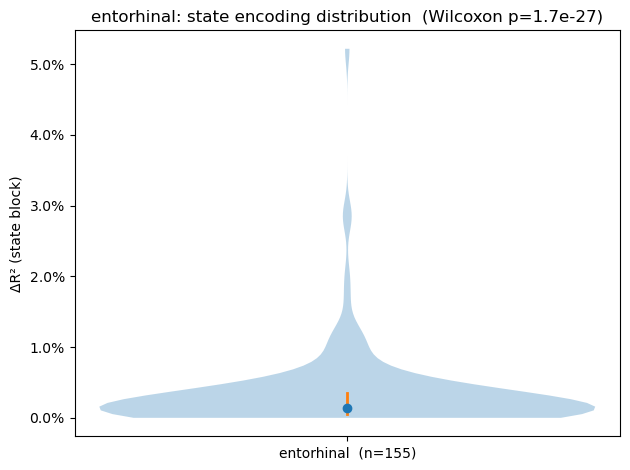

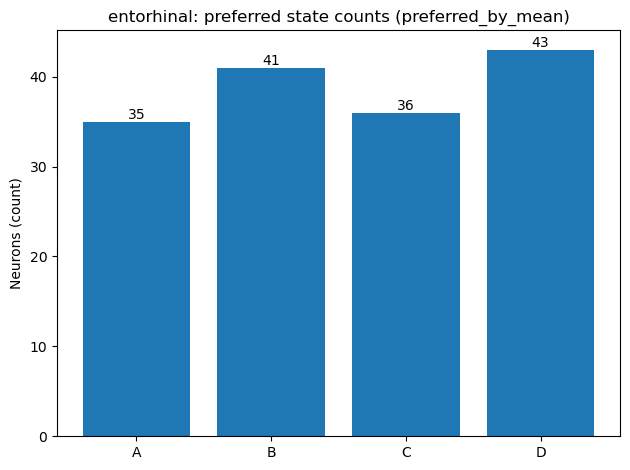

[entorhinal] missing pref_at_rep0/pref_at_rep1


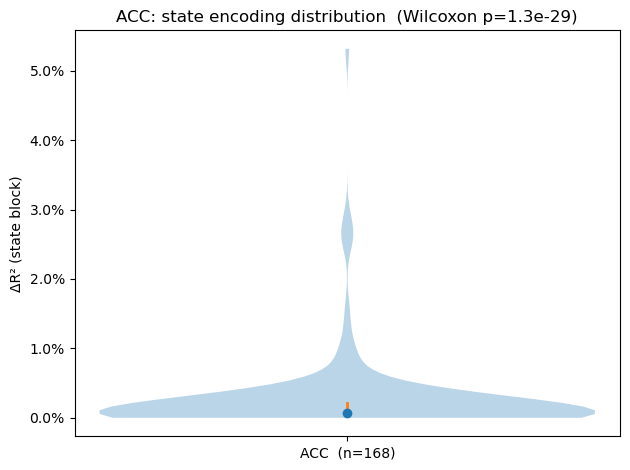

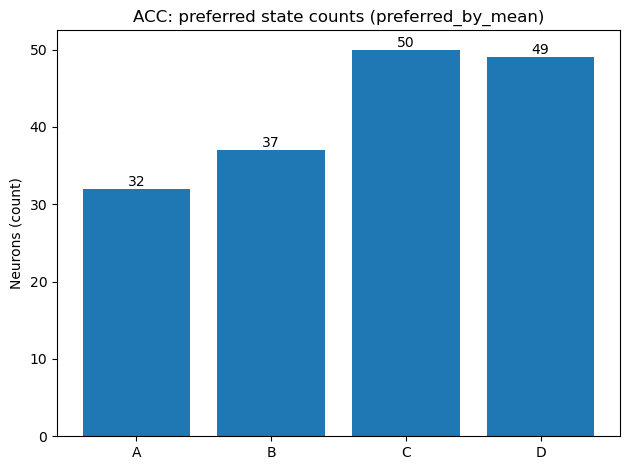

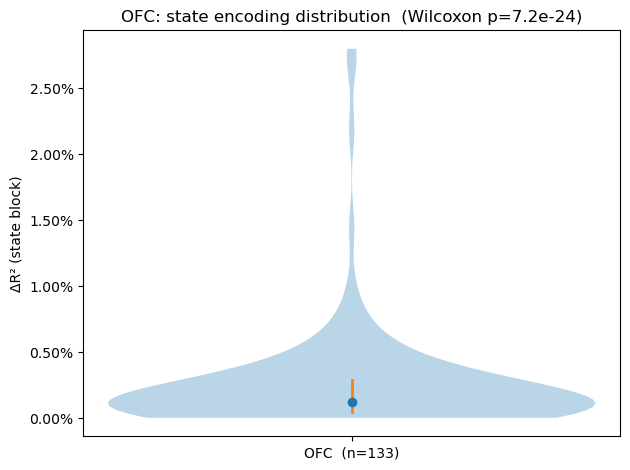

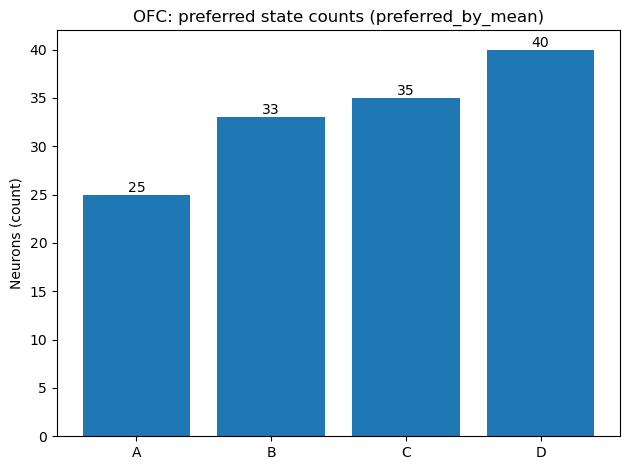

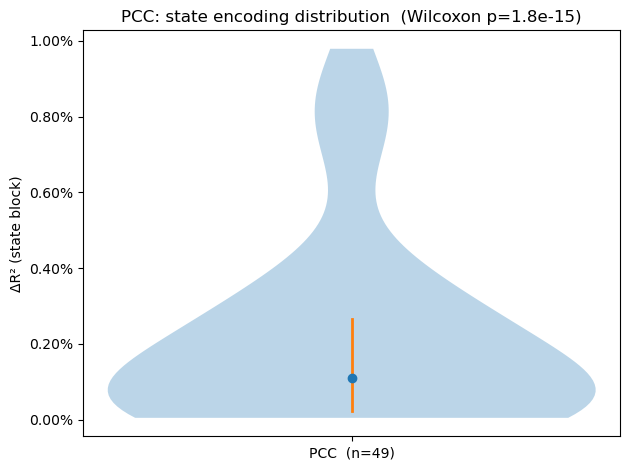

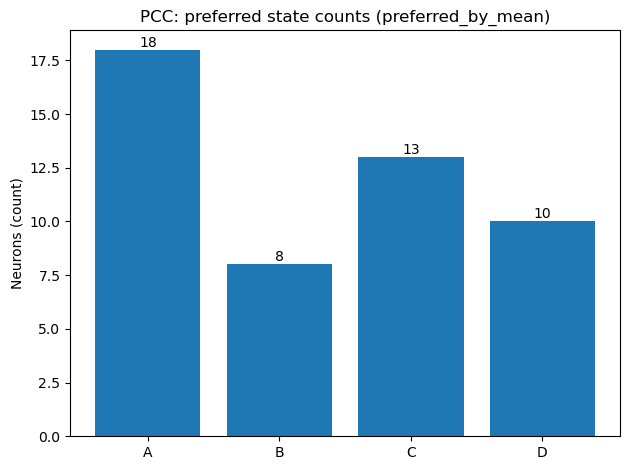

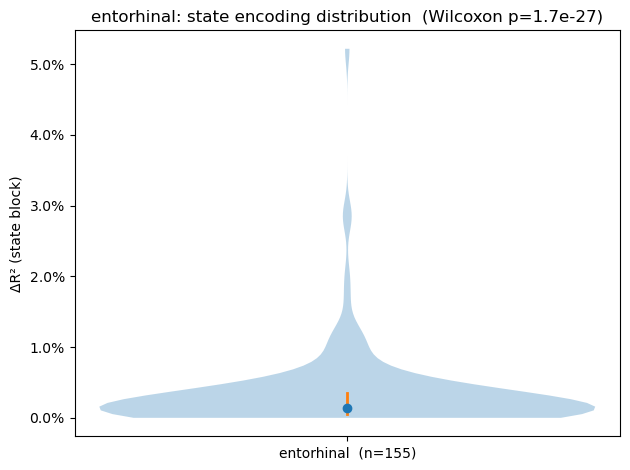

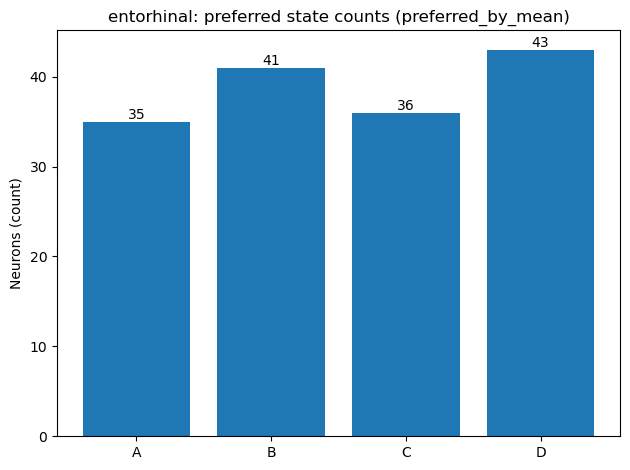

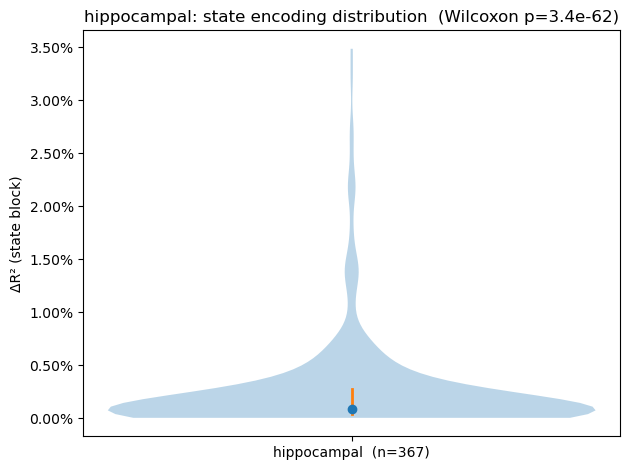

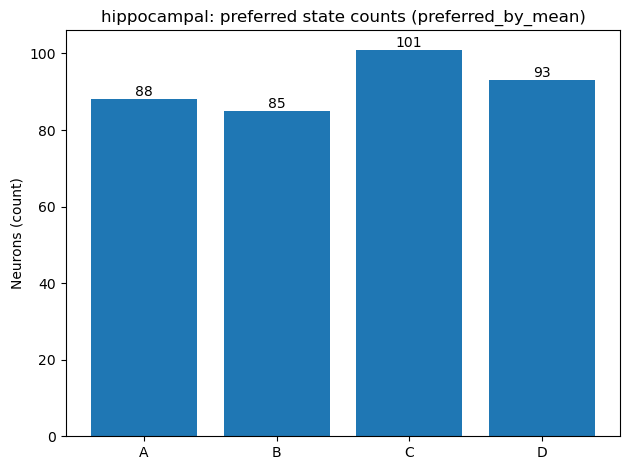

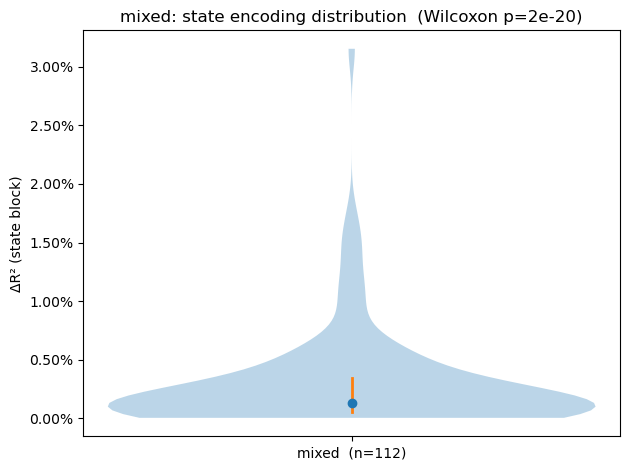

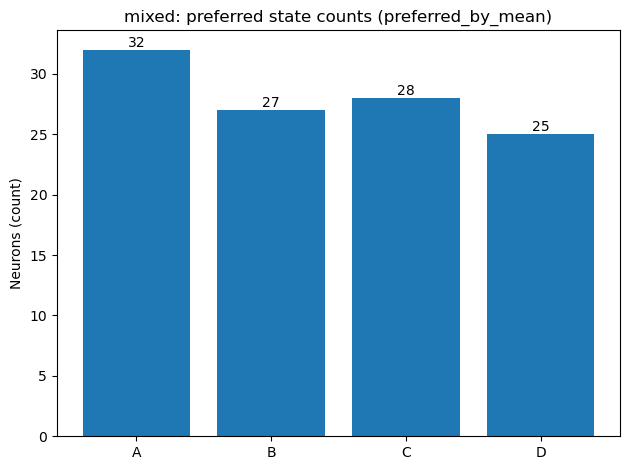

In [90]:
# One region:
plot_region_state_effect(per_neuron_all, "entorhinal")
plot_region_state_preference_counts(per_neuron_all, "entorhinal")
# (if you computed pref_at_rep0/pref_at_rep1)
plot_region_preference_by_repeat(per_neuron_all, "entorhinal")

# All regions:
for area in sorted(per_neuron_all["area"].unique()):
    plot_region_state_effect(per_neuron_all, area)
    plot_region_state_preference_counts(per_neuron_all, area)


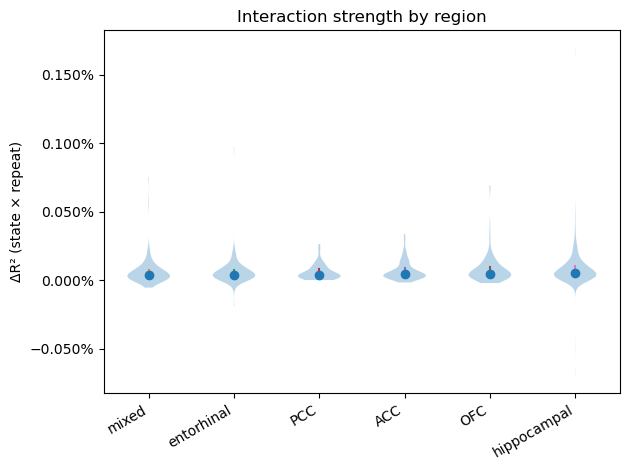

In [91]:
plot_interaction_distribution(per_neuron_all)

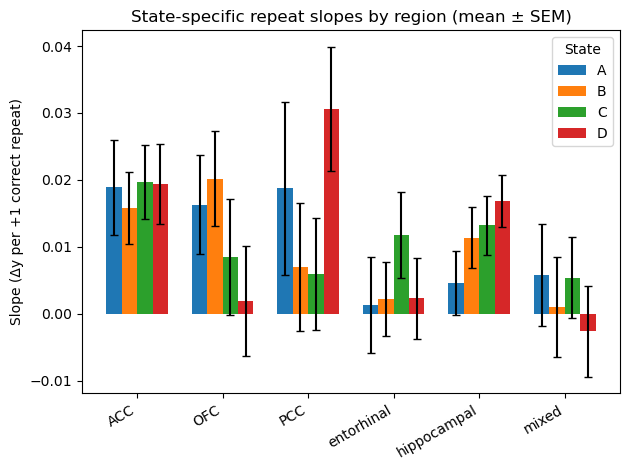

In [92]:
plot_state_slopes_by_region(per_neuron_all)

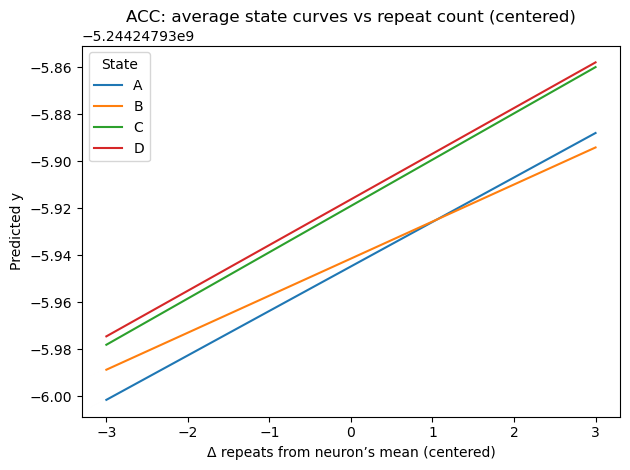

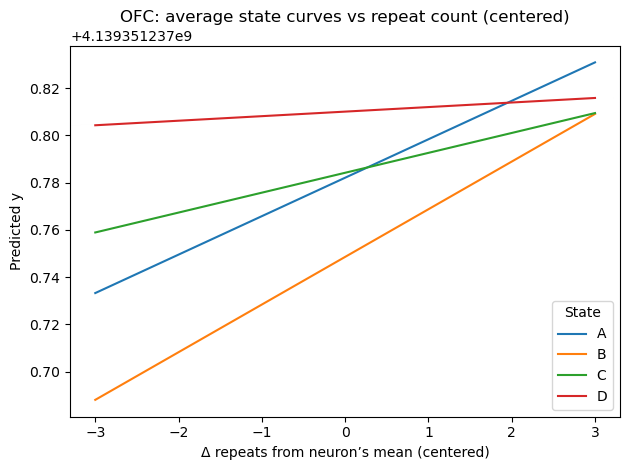

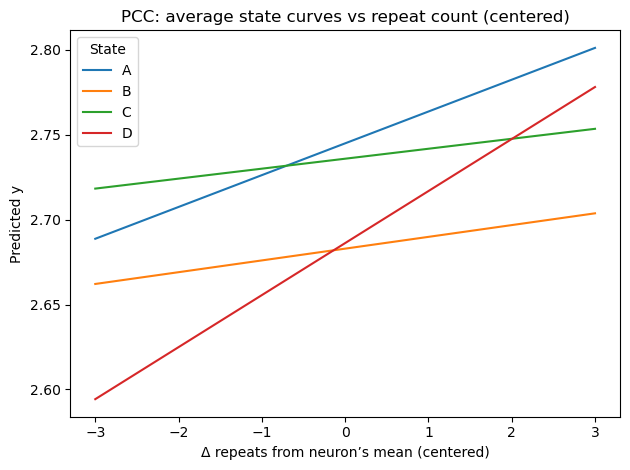

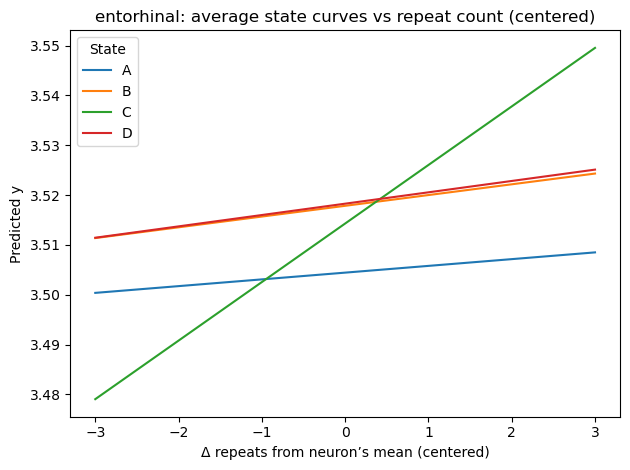

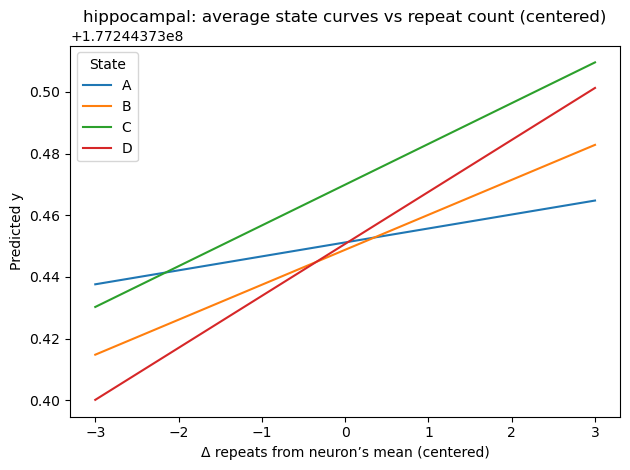

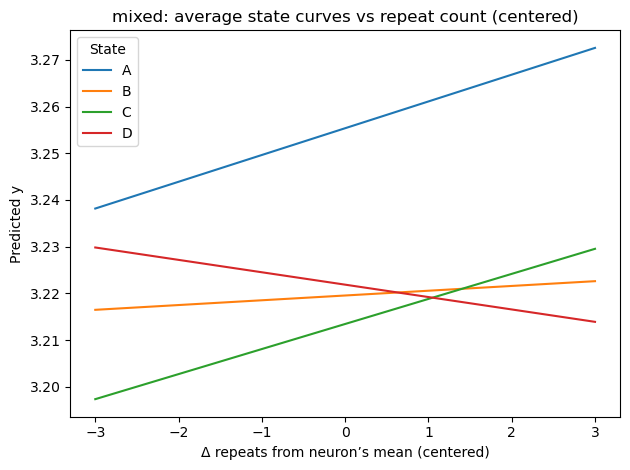

In [93]:
for area in sorted(per_neuron_all["area"].unique()):
    plot_area_fan(per_neuron_all, area)

In [94]:
per_neuron_all.head()

,neuron_id,area,session,subject,overall_R2,deltaR2_state,deltaR2_A,deltaR2_B,deltaR2_C,deltaR2_D,...,slope_C,slope_D,adj_A,adj_B,adj_C,adj_D,preferred_by_mean,preferred_by_delta,deltaR2_stateXrep,p_stateXrep
0,01_01-01-chan99-OFC,OFC,1,sub-01,0.000251,0.003165,0.002754,0.002841,0.002952,0.002433,...,-0.109009,0.040253,4.804244,4.879093,4.973803,4.515034,C,C,0.000076,0.331954
1,01_04-04-chan113-EC,entorhinal,1,sub-01,0.000354,0.000384,0.000364,0.000204,0.000255,0.000260,...,0.055496,0.001129,0.642463,0.481078,0.537671,0.542347,A,A,0.000198,0.030390
2,01_05-05-chan116-EC,entorhinal,1,sub-01,0.000336,0.006222,0.005490,0.005177,0.004815,0.005966,...,0.040469,-0.062371,7.384429,7.171021,6.915591,7.698195,D,D,0.000066,0.397483
3,01_06-06-chan119-EC,entorhinal,1,sub-01,0.001727,0.003723,0.003027,0.002079,0.001719,0.001204,...,0.077065,0.047493,3.495182,2.896796,2.633712,2.204433,A,A,0.000178,0.045612
4,01_07-07-chan120-EC,entorhinal,1,sub-01,0.000877,0.001626,0.001421,0.001379,0.001562,0.001319,...,-0.057617,0.018265,1.345385,1.325496,1.410394,1.296365,C,C,0.000239,0.013165


In [95]:
len(per_neuron_all)

984

In [97]:
print(per_neuron_all.columns)

Index(['neuron_id', 'area', 'session', 'subject', 'overall_R2',
       'deltaR2_state', 'deltaR2_A', 'deltaR2_B', 'deltaR2_C', 'deltaR2_D',
       'beta_rep', 'gamma_A', 'gamma_B', 'gamma_C', 'gamma_D', 'slope_A',
       'slope_B', 'slope_C', 'slope_D', 'adj_A', 'adj_B', 'adj_C', 'adj_D',
       'preferred_by_mean', 'preferred_by_delta', 'deltaR2_stateXrep',
       'p_stateXrep'],
      dtype='object')


In [146]:
# START AGAIN.
# get one p-value per regressor, and bonferroni correct for amount of neurons (in this area)
# also test the distribution of slopes per ROI against zero



# first step: load data of a single neuron.

# I THINK that session 50, 05 elect36 left insular, is an A state-neuron. look at that one first.
# '50_05-05-elec36-LINS'
sesh = 50
trials = 'all_minus_explore'
# load data
data_raw, source_dir = get_data(sesh, trials=trials)
group_dir_state = f"{source_dir}/group/state_tuning"

print(f"this is the folder {group_dir_state}")


# filter data for only those repeats that were 1) correct and 2) not the first one
data = mc.analyse.helpers_human_cells.filter_data(data_raw, sesh, trials)
beh_df = data[f"sub-{sesh:02}"]['beh'].copy()
neurons = data[f"sub-{sesh:02}"]['normalised_neurons'].copy()
neuron_labels = []
roi_label = []
for n in neurons:
    neuron_labels.append(n)
    if 'ACC' in n or 'vCC' in n or 'AMC' in n or 'vmPFC' in n:
                roi = 'ACC'
    elif 'PCC' in n:
        roi = 'PCC'
    elif 'OFC' in n:
        roi = 'OFC'
    elif 'MCC' in n or 'HC' in n:
        roi = 'hippocampal'
    elif 'EC' in n:
        roi = 'entorhinal'
    elif 'AMYG' in n:
        roi = 'amygdala'
    else:
        roi = 'mixed'
    roi_label.append(roi)
    
# next, transform into long format:
# one long df that is 248*360 long, 
#neuron: np.ndarray of shape (248, 360)  # trials x bins
#    beh_df: pd.DataFrame with length 248 and columns: 'rep_correct', 'grid_no', 'correct'
#    Returns a long/tidy DataFrame with 248*360 rows and columns:
#      - y (the original neuron values)
#      - state (A/B/C/D per 90 bins)
#      - state_phase (A_early, A_mid, A_rew, ..., D_rew per 30 bins)
#      - rep_correct, grid_no, correct (repeated for each trial across its 360 bins)
neuron = neurons['50_05-05-elec36-LINS'].to_numpy()
df = make_long_df(neuron, beh_df)
df.head()

df_state_mean = make_long_df_mean_per_state(neuron, beh_df)




print(len(df_state_mean))
print(len(df))

df.head()

loading files for subject 50
this is the folder /Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives/group/state_tuning


KeyError: ['A', 'B', 'C', 'D']

In [140]:
# now, fit the full model with interaction terms.
# get one p-value per regressor -> for group stats
# and the beta (slope) per regressor -> for group stats

cols = ["A","B","C","D","rep_c","correct"]

X = df_curr_neuron[cols].to_numpy(float)
y = df_curr_neuron["y"].to_numpy(float)
res = sm.OLS(y, X).fit(cov_type="HC3")

tab = pd.DataFrame({
    "beta":   res.params,
    "t":      res.tvalues,
    "pval":   res.pvalues,
}, index=cols)

# Block tests
state_F  = res.f_test("A = B = C = D = 0")
inter_F  = res.f_test("A_rep = B_rep = C_rep = D_rep = 0")

    